# Load Libraries

In [1205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from category_encoders import TargetEncoder
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from geopy.distance import geodesic
# !pip install geopy

from warnings import filterwarnings
filterwarnings('ignore')


In [1134]:
file_path = r"C:\Users\aravit01\OneDrive - Kearney\1. RAVI TEJA\12. My Learnings\Portfolio Projects to Showcase\food delivery prediction\train.csv"
df = pd.read_csv(file_path)
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [1135]:
df.shape

(45593, 20)

In [1136]:
df.isnull().sum()

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weatherconditions              0
Road_traffic_density           0
Vehicle_condition              0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
Time_taken(min)                0
dtype: int64

In [1137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [1138]:
df.duplicated().sum()

0

observations:
- ID feature can be dropped directly
- Delivery_person_ID needs transformation
- Delivery_person_Age dtype change
- based on lat & long, we need to calculate distance from source (resturant) to destination (customer)
- Order_Date dtype change
- Time_Orderd, Time_Order_picked transformation required to form new feature preparation time
- Weatherconditions: conditions to be removed
- Time_taken(min): min() to be removed

In [1139]:
df = df.drop(columns='ID', axis =1)

In [1140]:
df.columns = df.columns.str.lower()

In [1141]:
df['city_code'] = df['delivery_person_id'].str.split('RES', expand=True)[0]

In [1142]:
df['delivery_person_id'] = df['delivery_person_id'].str.split('RES', expand=True)[1]

In [1143]:
df['weatherconditions'] = df['weatherconditions'].str.split(' ', expand=True)[1]

In [1144]:
df['time_taken(min)'] = df['time_taken(min)'].str.split(' ', expand=True)[1]

### function to convert nan values to median for numerical values

In [1145]:
def numerical_values_nulls_median(df, col):
    df[col] = df[col].replace(['NaN', 'NaN '], np.nan)
    df[col] = df[col].fillna(df[col].median())

In [1146]:
numerical_values_nulls_median(df, 'delivery_person_age')

In [1147]:
numerical_values_nulls_median(df, 'delivery_person_ratings')

### function to convert nan values to median for numerical values

In [1148]:
def categorical_values_nulls_mode(df, col):
    df[col] = df[col].replace(['NaN', 'NaN '], np.nan)
    df[col] = df[col].fillna(df[col].mode()[0])

In [1149]:
categorical_values_nulls_mode(df,'multiple_deliveries')

In [1150]:
categorical_values_nulls_mode(df,'festival')

In [1151]:
categorical_values_nulls_mode(df,'weatherconditions')

In [1152]:
categorical_values_nulls_mode(df,'road_traffic_density')

In [1153]:
categorical_values_nulls_mode(df,'city')

In [1154]:
df['order_date'] = pd.to_datetime(df['order_date'])

In [1155]:
df['week(y/n'] = df['order_date'].dt.day_name().apply(lambda x: 'weekend' if x in ['Sunday','Saturday'] else 'weekday')

In [1156]:
df['distance'] = round(df.apply(lambda row: geodesic((row['restaurant_latitude'], row['restaurant_longitude']), (row['delivery_location_latitude'], row['delivery_location_longitude'])).kilometers,
    axis=1),0)

In [1157]:
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,...,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken(min),city_code,week(y/n,distance
0,13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,...,2,Snack,motorcycle,0,No,Urban,24,INDO,weekend,3.0
1,18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,...,2,Snack,scooter,1,No,Metropolitian,33,BANG,weekday,20.0


### change datatypes

In [1158]:
df['delivery_person_age'] = df['delivery_person_age'].astype('int')
df['delivery_person_ratings'] = df['delivery_person_ratings'].astype('float')
df['vehicle_condition'] = df['vehicle_condition'].astype('int')
df['multiple_deliveries'] = df['multiple_deliveries'].astype('int')
df['time_taken(min)'] = df['time_taken(min)'].astype('int')
df['distance'] = df['distance'].astype('int')

In [1159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   delivery_person_id           45593 non-null  object        
 1   delivery_person_age          45593 non-null  int32         
 2   delivery_person_ratings      45593 non-null  float64       
 3   restaurant_latitude          45593 non-null  float64       
 4   restaurant_longitude         45593 non-null  float64       
 5   delivery_location_latitude   45593 non-null  float64       
 6   delivery_location_longitude  45593 non-null  float64       
 7   order_date                   45593 non-null  datetime64[ns]
 8   time_orderd                  45593 non-null  object        
 9   time_order_picked            45593 non-null  object        
 10  weatherconditions            45593 non-null  object        
 11  road_traffic_density         45593 non-nu

### drop unneccessary cols for analysis

In [1160]:
cols_to_drop = ['restaurant_latitude','restaurant_longitude','delivery_location_latitude','delivery_location_longitude','order_date','time_orderd','time_order_picked']

df2 = df.drop(columns=cols_to_drop, axis=1)

observations:
- numerical features which have null values are replaced with median
- categorical features which have null values are replaced with mode
- dtypes needs to be changed according
- we dont require latitudes, longitude, since we found distance. so these cols can be dropped
- order_date is transformed to weekday, weekend, even that can be dropped
- time_ordered, time_picked are dropped

In [1161]:
df2.head()

,delivery_person_id,delivery_person_age,delivery_person_ratings,weatherconditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken(min),city_code,week(y/n,distance
0,13DEL02,37,4.9,Sunny,High,2,Snack,motorcycle,0,No,Urban,24,INDO,weekend,3
1,18DEL02,34,4.5,Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,33,BANG,weekday,20
2,19DEL01,23,4.4,Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,26,BANG,weekend,2
3,13DEL02,38,4.7,Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,21,COIMB,weekday,8
4,12DEL01,32,4.6,Cloudy,High,1,Snack,scooter,1,No,Metropolitian,30,CHEN,weekend,6


In [1162]:
df2 = df2[df2['distance']<30]

In [1163]:
df2 = df2[df2['delivery_person_ratings']<=5]

In [1164]:
df2.select_dtypes(include='object').columns

Index(['delivery_person_id', 'weatherconditions', 'road_traffic_density',
       'type_of_order', 'type_of_vehicle', 'festival', 'city', 'city_code',
       'week(y/n'],
      dtype='object')

In [1165]:
for i in df2.select_dtypes(include='object').columns:
    df2[i] = df2[i].str.strip()

In [1166]:
df2['city_code'].unique()

array(['INDO', 'BANG', 'COIMB', 'CHEN', 'HYD', 'RANCHI', 'MYS', 'DEH',
       'KOC', 'PUNE', 'LUDH', 'KNP', 'MUM', 'KOL', 'JAP', 'SUR', 'GOA',
       'AURG', 'AGR', 'VAD', 'ALH', 'BHP'], dtype=object)

# EDA

In [1167]:
df2.columns

Index(['delivery_person_id', 'delivery_person_age', 'delivery_person_ratings',
       'weatherconditions', 'road_traffic_density', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city', 'time_taken(min)', 'city_code', 'week(y/n', 'distance'],
      dtype='object')

## find skewness

In [1168]:
for i in df2.select_dtypes(exclude='object').columns:
    print(f"{i}: {round(df2[i].skew(),2)}")

delivery_person_age: -0.03
delivery_person_ratings: -2.51
vehicle_condition: 0.05
multiple_deliveries: 0.3
time_taken(min): 0.48
distance: 0.34


observations:
- positive value indicates -> right-skewed(longer right tail)
- negative values indicated -> left-skewed(longer left tail)
- 0 or close 0 indicates -> normally distributed

## find kurtosis

In [1169]:
for i in df2.select_dtypes(exclude='object').columns:
    print(f"{i}: {round(df2[i].kurtosis(),2)}")

delivery_person_age: -1.13
delivery_person_ratings: 14.33
vehicle_condition: -1.36
multiple_deliveries: 0.95
time_taken(min): -0.31
distance: -0.9


observations:
- positive value indicates -> more outliers
- negative values indicated -> fewer outliers
- 0 or close 0 indicates -> normal distribution

## find outliers using IQR

In [1170]:
def get_iqr(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    return (print(f"{col}: ({lower_bound, upper_bound})"))


In [1171]:
for i in df2.select_dtypes(exclude='object').columns:
    get_iqr(df2, i)

delivery_person_age: ((11.5, 47.5))
delivery_person_ratings: ((4.050000000000001, 5.25))
vehicle_condition: ((-3.0, 5.0))
multiple_deliveries: ((-1.5, 2.5))
time_taken(min): ((-0.5, 51.5))
distance: ((-8.5, 27.5))


In [1172]:
num_cols_to_plot = ['delivery_person_age', 'delivery_person_ratings','vehicle_condition',
                    'multiple_deliveries',  'time_taken(min)', 'distance']

len(num_cols_to_plot)

6

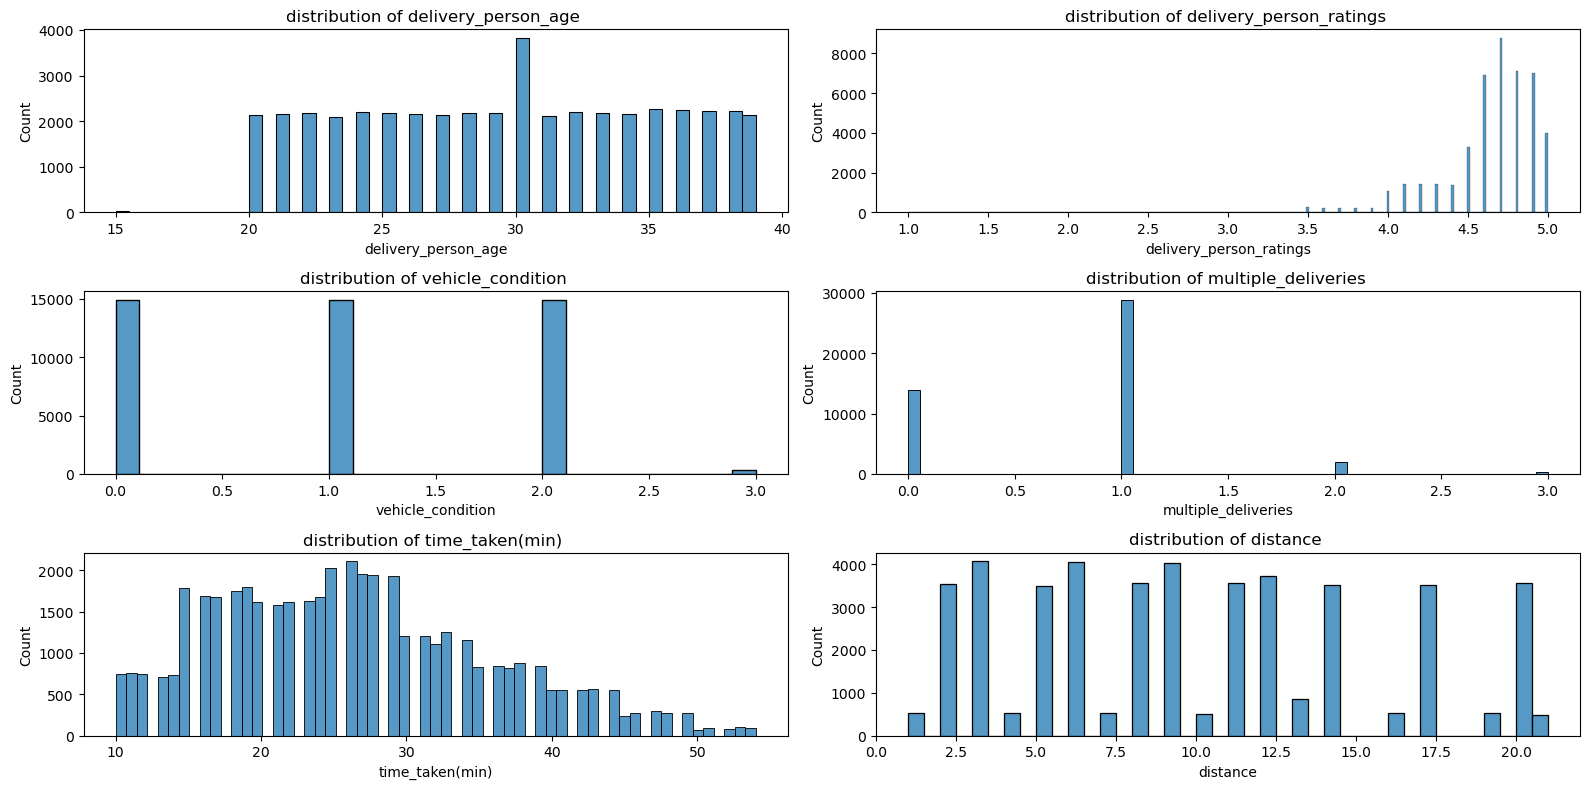

In [1173]:
nrows = len(num_cols_to_plot)//2
fig, axes = plt.subplots(nrows, 2, figsize=(16,8))

axes = axes.flatten()

for cols, ax in zip(num_cols_to_plot,axes):
    sns.histplot(data=df2, x=cols, ax=ax)
    ax.set_title(f"distribution of {cols} ")
    
    
plt.tight_layout()
plt.show()

observations:
- age group 30 delivered highest orders
- ratings with 4.5 to 4.9 had more orders
- most of the orders took around 15-25 mins to deliver

In [1174]:
cat_cols_to_plot = ['weatherconditions', 'road_traffic_density','type_of_order', 'type_of_vehicle', 'festival',
       'city', 'city_code', 'week(y/n']

len(cat_cols_to_plot)

8

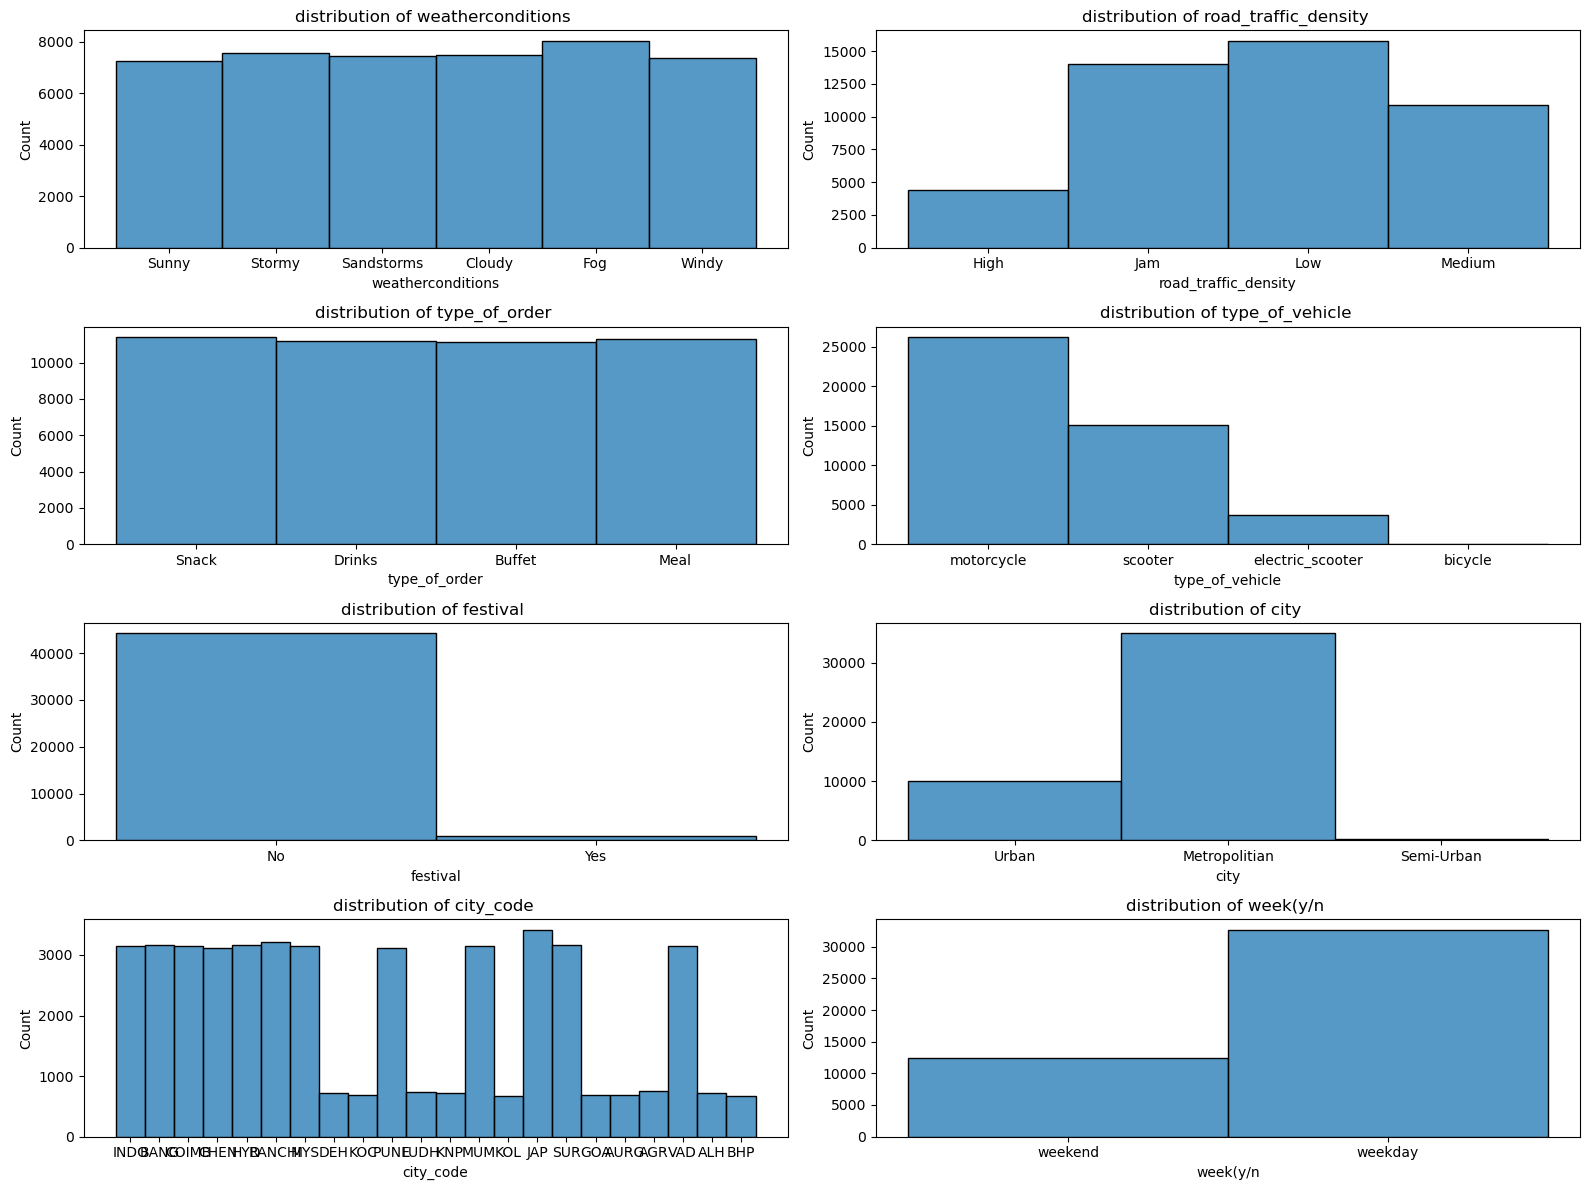

In [1175]:
nrows = len(cat_cols_to_plot)//2 
fig, axes = plt.subplots(nrows, 2, figsize=(16,12))

axes = axes.flatten()

for cols, ax in zip(cat_cols_to_plot,axes):
    sns.histplot(data=df2, x=cols, ax=ax)
    ax.set_title(f"distribution of {cols} ")
    
    
plt.tight_layout()
plt.show()

observations:
- when its fog & stromy spike in no.of orders
- when traffic condition is low, more of orders delivered
- meals & snacks ordered the most
- delivery boys how have motorcycle had highest delivers (fastest means of transport)
- during festial, most prefer to eat homely food, so less orders
- metropolitian cities have highest orders compared with urban, semi-urban
- surprisingly weekday have most orders compared weekend.

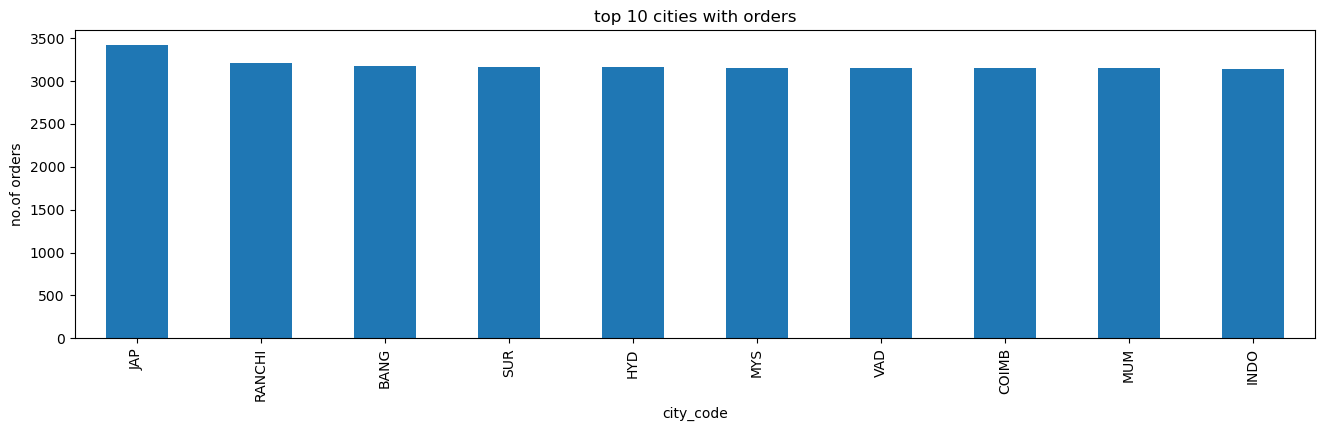

In [1176]:
plt.figure(figsize = (16,4))

top_city_orders = df2.groupby(by='city_code')['delivery_person_id'].count().sort_values(ascending=False).head(10)
top_city_orders.plot(kind='bar')
plt.title('top 10 cities with orders')
plt.ylabel('no.of orders')

plt.show()

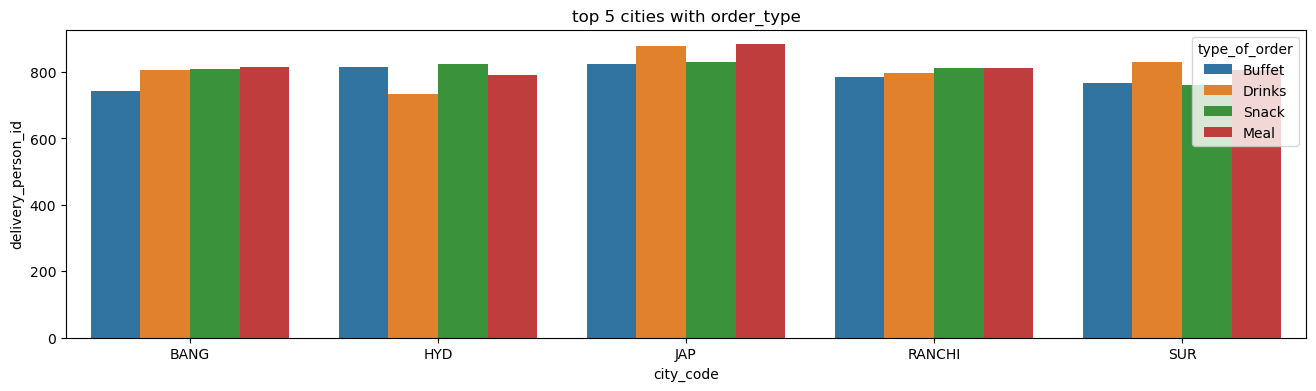

In [1177]:
city_vs_order_type = df2.groupby(by=['city_code','type_of_order'])['delivery_person_id'].count().sort_values(ascending=False).reset_index()
city_vs_order_type.sort_values(by=['city_code','delivery_person_id'], ascending=[True, False],inplace=True)
city_vs_order_type['rank'] = city_vs_order_type.groupby('city_code')['delivery_person_id'].rank(method='max', ascending=False)
city_vs_order_type.sort_values('delivery_person_id', ascending=False, inplace=True)
top5_city_order_type = city_vs_order_type[city_vs_order_type['city_code'].isin(top_city_orders.reset_index()['city_code'].head(5).to_list())].sort_values(['city_code','rank'],ascending=[True,False])
top5_city_order_type

plt.figure(figsize=(16,4))
sns.barplot(data=top5_city_order_type, x='city_code', y='delivery_person_id', hue='type_of_order')
plt.title('top 5 cities with order_type')
plt.show()


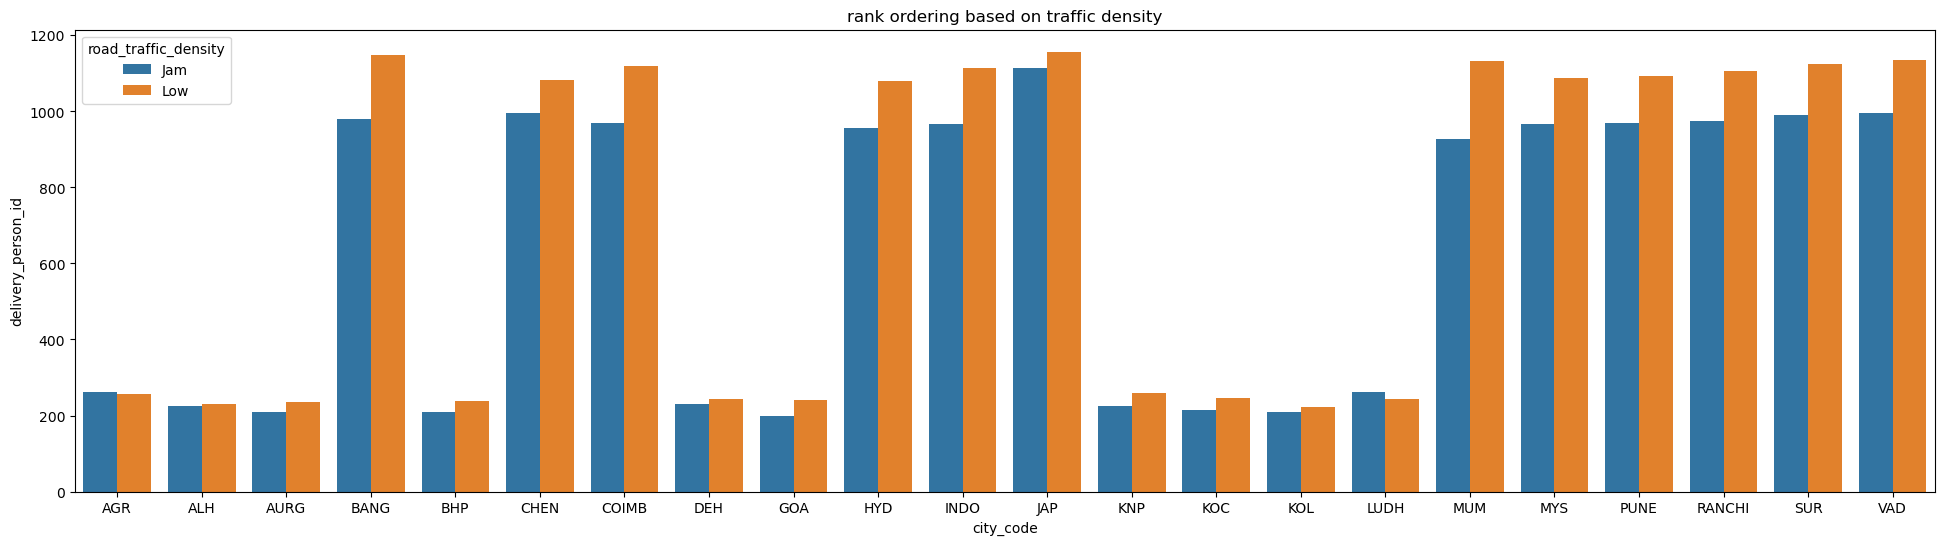

In [1178]:
city_vs_density = df2.groupby(['city_code','road_traffic_density'])['delivery_person_id'].count().reset_index().sort_values(by=['city_code','delivery_person_id'], ascending=[True,False])
city_vs_density['rank'] = city_vs_density.groupby('city_code')['delivery_person_id'].rank(method='max', ascending=False)
city_vs_traffice_order_density = city_vs_density[city_vs_density['rank'].isin([1,2])]

plt.figure(figsize=(24,6))
sns.barplot(data=city_vs_traffice_order_density, x='city_code', y='delivery_person_id', hue='road_traffic_density')
plt.title('rank ordering based on traffic density')

plt.show()

observation:
- low traffice density = high orders
- medium td = medium orders
- high td = low orders
- interesting even traffice is JAM, delivered more orders than mediumm & high

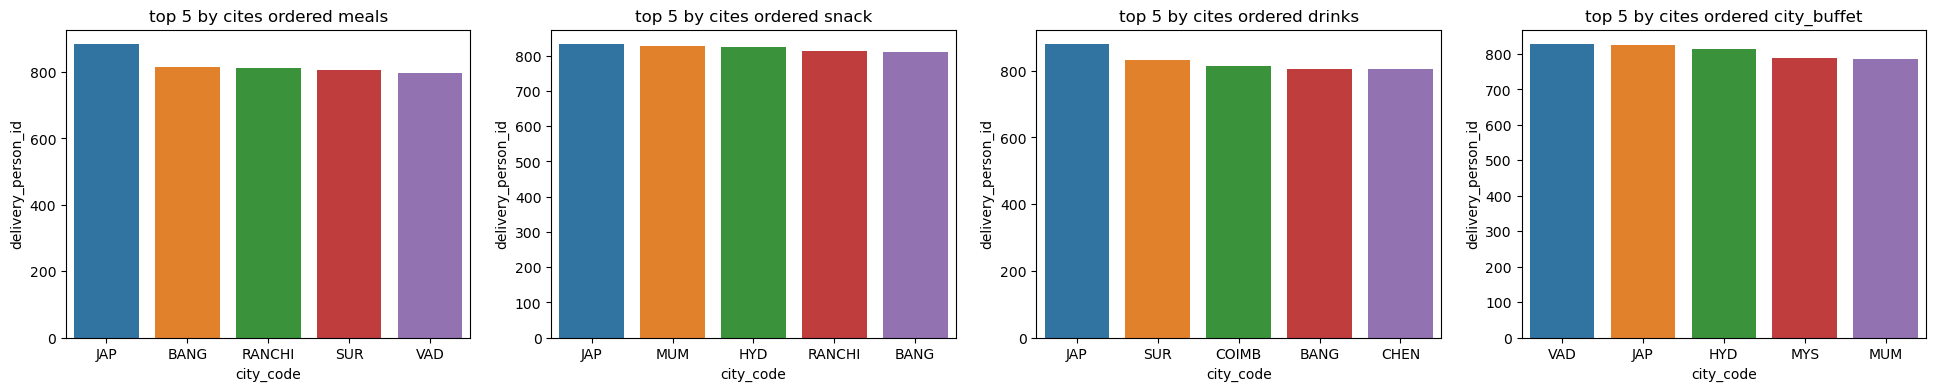

In [1179]:
city_vs_snack = df2.groupby(['city_code','type_of_order'])['delivery_person_id'].count().reset_index()

plt.subplots(1,4,figsize=(24,4))

plt.subplot(1,4,1)
city_meal = city_vs_snack[city_vs_snack['type_of_order'] == 'Meal'].sort_values('delivery_person_id', ascending=False).head(5)
sns.barplot(data=city_meal, x='city_code',y='delivery_person_id')
plt.title('top 5 by cites ordered meals')

plt.subplot(1,4,2)
city_snacks = city_vs_snack[city_vs_snack['type_of_order'] == 'Snack'].sort_values('delivery_person_id', ascending=False).head(5)
sns.barplot(data=city_snacks, x='city_code',y='delivery_person_id')
plt.title('top 5 by cites ordered snack')

plt.subplot(1,4,3)
city_drinks = city_vs_snack[city_vs_snack['type_of_order'] == 'Drinks'].sort_values('delivery_person_id', ascending=False).head(5)
sns.barplot(data=city_drinks, x='city_code',y='delivery_person_id')
plt.title('top 5 by cites ordered drinks')

plt.subplot(1,4,4)
city_buffet = city_vs_snack[city_vs_snack['type_of_order'] == 'Buffet'].sort_values('delivery_person_id', ascending=False).head(5)
sns.barplot(data=city_buffet, x='city_code',y='delivery_person_id')
plt.title('top 5 by cites ordered city_buffet')


plt.show()


observations:
- above visual provides information on food style habits leaving in cities based on orders
- interesting to observe JAP stands top all order_types (foodie 😄)

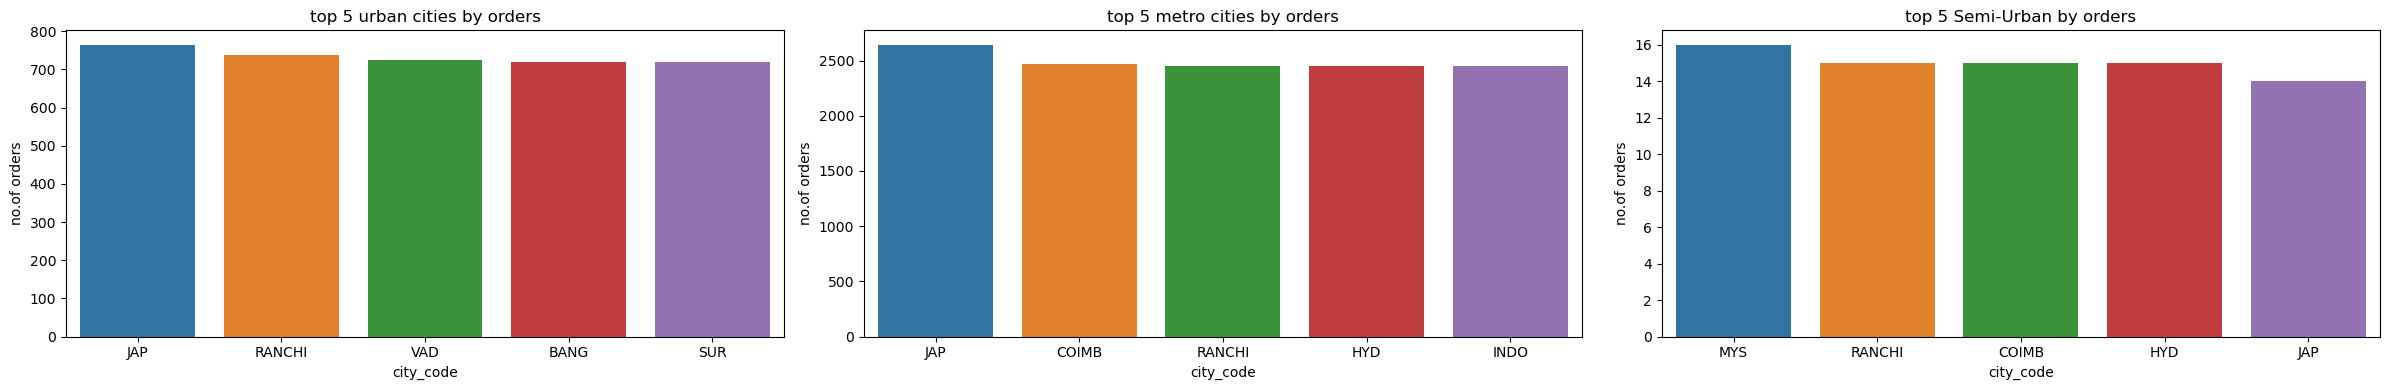

In [1180]:

plt.subplots(1,3,figsize=(24,4))

citycode_vs_city = df2.groupby(by=['city_code','city'])['delivery_person_id'].count().reset_index()

plt.subplot(1,3,1) 
city_urban = citycode_vs_city[citycode_vs_city['city'] == 'Urban'].sort_values('delivery_person_id', ascending=0).head(5)
sns.barplot(data=city_urban, x='city_code',y='delivery_person_id')
plt.title('top 5 urban cities by orders')
plt.ylabel('no.of orders')

plt.subplot(1,3,2) 
city_metro = citycode_vs_city[citycode_vs_city['city'] == 'Metropolitian'].sort_values('delivery_person_id', ascending=0).head(5)
sns.barplot(data=city_metro, x='city_code',y='delivery_person_id')
plt.title('top 5 metro cities by orders')
plt.ylabel('no.of orders')

plt.subplot(1,3,3) 
city_smurban = citycode_vs_city[citycode_vs_city['city'] == 'Semi-Urban'].sort_values('delivery_person_id', ascending=0).head(5)
sns.barplot(data=city_smurban, x='city_code',y='delivery_person_id')
plt.title('top 5 Semi-Urban by orders')
plt.ylabel('no.of orders')


plt.tight_layout()
plt.show()

observations:
- there is huge gaps/randomness in orders for semi-urban Vs urban Vs metro cities
- metro cities orders 10X more than urbans
- metro cities orders 100X more than semi-urbans

In [1181]:
df2['city'].unique()

array(['Urban', 'Metropolitian', 'Semi-Urban'], dtype=object)

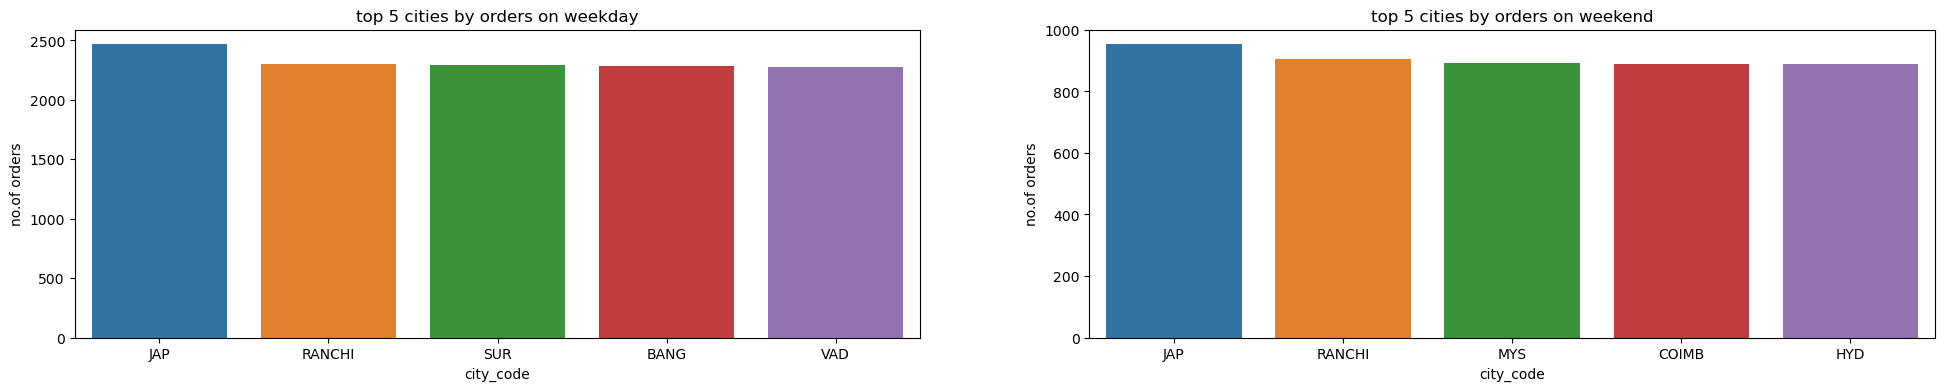

In [1182]:
city_vs_week = df2.groupby(['city_code','week(y/n'])['delivery_person_id'].count().reset_index()
plt.subplots(1,2,figsize=(24,4))

plt.subplot(1,2,1) 
city_vs_weekday = city_vs_week[city_vs_week['week(y/n']=='weekday'].sort_values(by='delivery_person_id', ascending=0).head(5)
sns.barplot(data=city_vs_weekday, x='city_code',y='delivery_person_id')
plt.title('top 5 cities by orders on weekday')
plt.ylabel('no.of orders')

plt.subplot(1,2,2) 
city_vs_weekend = city_vs_week[city_vs_week['week(y/n']=='weekend'].sort_values(by='delivery_person_id', ascending=0).head(5)
sns.barplot(data=city_vs_weekend, x='city_code',y='delivery_person_id')
plt.title('top 5 cities by orders on weekend')
plt.ylabel('no.of orders')

plt.show()

observations:
- hyd & mys cities perfer to order on weekends
- interesting order size on weekday is 2X of weekend

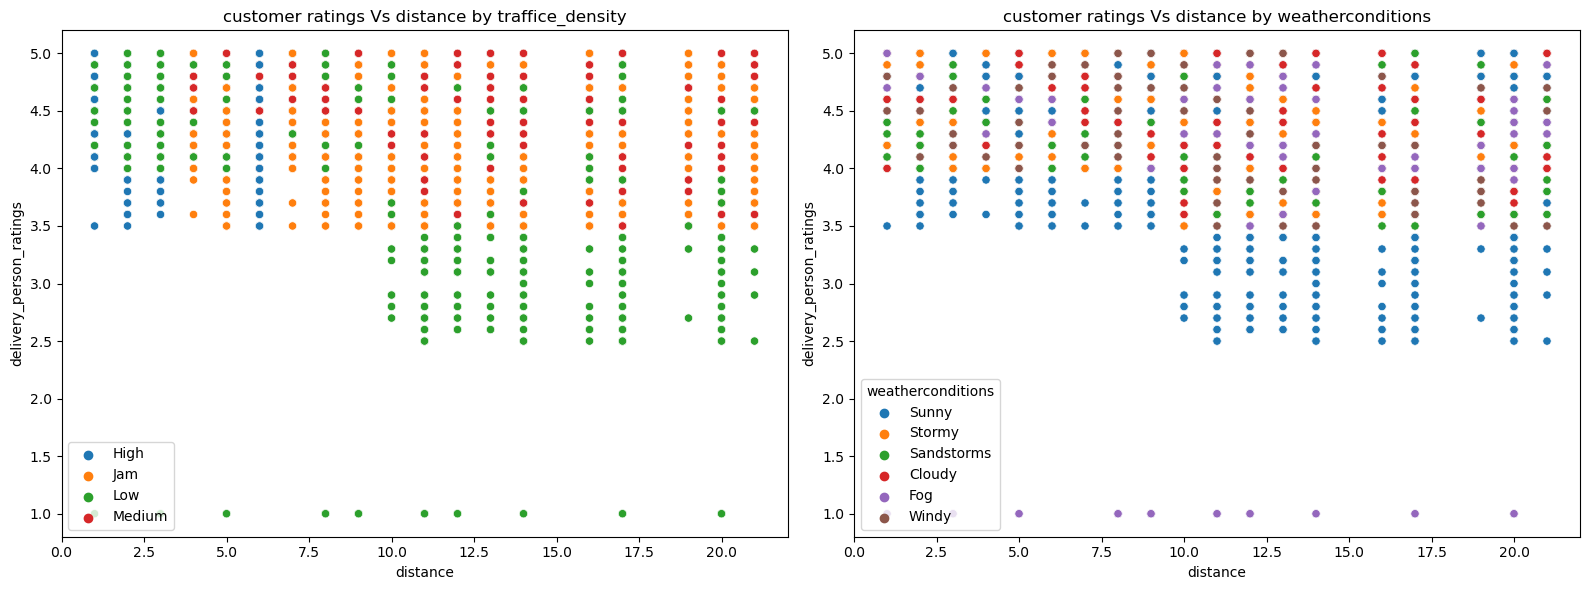

In [1183]:
plt.subplots(1,2,figsize=(16,6))

plt.subplot(1,2,1) 
sns.scatterplot(data=df2, x='distance', y='delivery_person_ratings', hue='road_traffic_density')
plt.legend(loc='lower left')
plt.title('customer ratings Vs distance by traffice_density')

plt.subplot(1,2,2) 
sns.scatterplot(data=df2, x='distance', y='delivery_person_ratings', hue = 'weatherconditions')
plt.title('customer ratings Vs distance by weatherconditions')


plt.tight_layout()
plt.show()


observations:
- as distance increase low traffic density & delivery persons ratings decreasing signifactly 
- most data points with distance > 10 kms has low traffice density
- delivery's on sunny conditions has low delivery rating 

In [1184]:
for i in df2.select_dtypes(include='object').columns:
    print(f"{i}: {df2[i].value_counts()}")

delivery_person_id: delivery_person_id
02DEL01     840
11DEL01     837
04DEL02     831
15DEL01     829
03DEL01     826
09DEL02     826
16DEL02     823
12DEL02     823
02DEL02     822
11DEL02     822
08DEL02     820
07DEL01     819
17DEL01     818
13DEL02     816
14DEL02     815
05DEL02     815
19DEL02     813
06DEL02     812
12DEL01     811
16DEL01     810
01DEL01     810
20DEL01     809
010DEL01    808
05DEL01     807
13DEL01     807
15DEL02     807
18DEL01     807
09DEL01     807
20DEL02     806
14DEL01     805
01DEL02     804
010DEL02    802
06DEL01     802
07DEL02     801
03DEL02     799
17DEL02     797
08DEL01     797
19DEL01     796
04DEL01     795
18DEL02     791
12DEL03     651
09DEL03     649
17DEL03     646
03DEL03     645
16DEL03     645
07DEL03     636
05DEL03     636
02DEL03     632
010DEL03    631
01DEL03     631
04DEL03     631
06DEL03     630
15DEL03     629
20DEL03     629
18DEL03     627
19DEL03     626
11DEL03     626
14DEL03     621
13DEL03     613
08DEL03     612
N

In [1185]:
len(df2.columns)

15

## correlation 

In [1186]:
cm = df2.select_dtypes(exclude='object').corr()
cm

,delivery_person_age,delivery_person_ratings,vehicle_condition,multiple_deliveries,time_taken(min),distance
delivery_person_age,1.000000,-0.093688,-0.004273,0.113462,0.297718,-0.001646
delivery_person_ratings,-0.093688,1.000000,0.031831,-0.115148,-0.338576,-0.102578
vehicle_condition,-0.004273,0.031831,1.000000,-0.095914,-0.236762,0.007225
multiple_deliveries,0.113462,-0.115148,-0.095914,1.000000,0.378697,0.123863
time_taken(min),0.297718,-0.338576,-0.236762,0.378697,1.000000,0.321808
distance,-0.001646,-0.102578,0.007225,0.123863,0.321808,1.000000


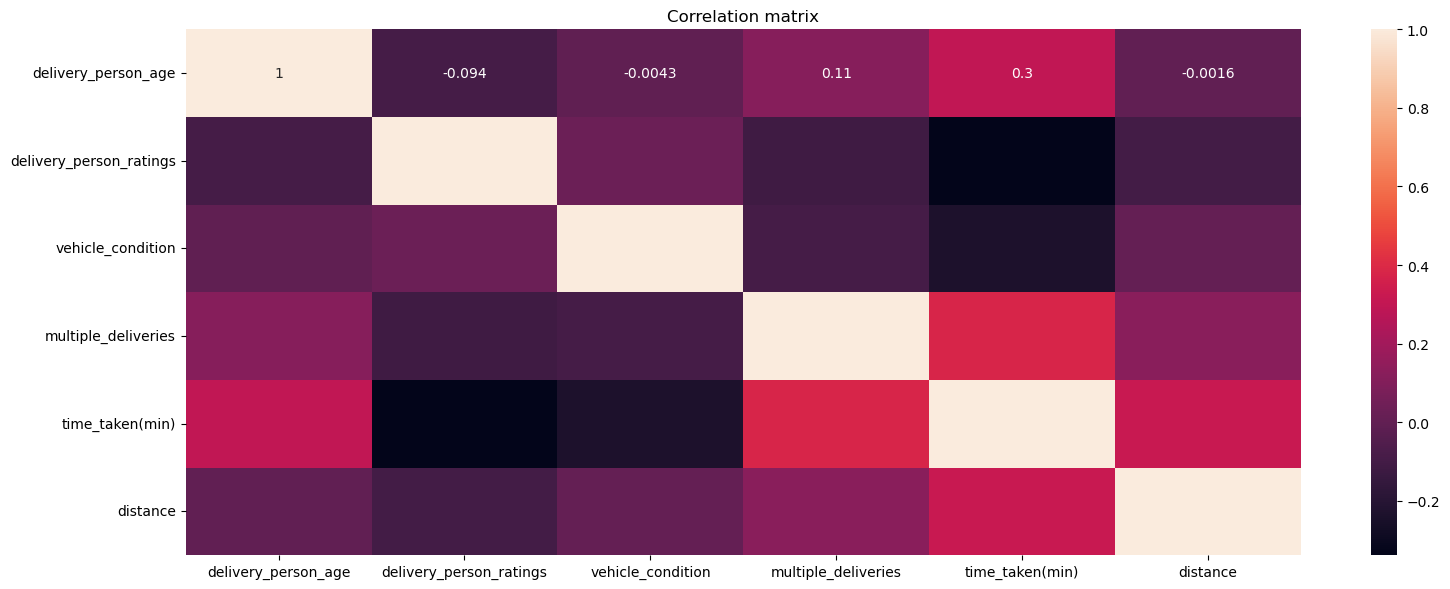

In [1187]:
plt.figure(figsize=(16,6))
sns.heatmap(data=cm, annot=True, fmt='.2g')
plt.title("Correlation matrix")

plt.tight_layout()
plt.show()

observations:
- correlation is applied only to numerical features.
- goal of correlation is to find strenght & direction of linear relationship
- 1 indicates -> postive correlation (when one feature increases, other feature increases & vice-versa) 
- -1 indicates -> negative correlation (when one feature increases, other feature decreases & vice-versa)
- 0 indicates -> No correlation 

# Encoding

In [1188]:
road_traffic_density_mapping = {
    'High':4,
    'Jam':3,
    'Medium':2,
    'Low':1
}

In [1189]:
df2['road_traffic_density'] = df2['road_traffic_density'].map(road_traffic_density_mapping)

In [1190]:
city_mapping = {
    'Urban':2,
    'Semi-Urban':1,
    'Metropolitian':3
}

In [1191]:
df2['city'] = df2['city'].map(city_mapping)

In [1192]:
week_mapping = {
    'weekend': 1,
    'weekday': 0
}

In [1193]:
festival_mapping = {
    'No': 0,
    'Yes': 1
}

In [1194]:
df2['festival'] = df2['festival'].map(festival_mapping) 

In [1195]:
df2['week(y/n'] = df2['week(y/n'].map(week_mapping)

## ohe_encoding

In [1196]:
cols_to_ohe = ['weatherconditions','type_of_order','type_of_vehicle']

In [1197]:
df3 = pd.get_dummies(data=df2, columns=cols_to_ohe, drop_first=True, dtype='int')

In [1198]:
df3.head(3)

,delivery_person_id,delivery_person_age,delivery_person_ratings,road_traffic_density,vehicle_condition,multiple_deliveries,festival,city,time_taken(min),city_code,...,weatherconditions_Sandstorms,weatherconditions_Stormy,weatherconditions_Sunny,weatherconditions_Windy,type_of_order_Drinks,type_of_order_Meal,type_of_order_Snack,type_of_vehicle_electric_scooter,type_of_vehicle_motorcycle,type_of_vehicle_scooter
0,13DEL02,37,4.9,4,2,0,0,2,24,INDO,...,0,0,1,0,0,0,1,0,1,0
1,18DEL02,34,4.5,3,2,1,0,3,33,BANG,...,0,1,0,0,0,0,1,0,0,1
2,19DEL01,23,4.4,1,0,1,0,2,26,BANG,...,1,0,0,0,1,0,0,0,1,0


observations:
- applied mapping for ordinal variables
- applied OHE before split, there is risk of categories present in training set & not in test set, this will cause an issue.
- applying these technqiue's before split doesnt cause any data leakage 

# Split data

In [1199]:
X = df3.drop(columns='time_taken(min)', axis=1)
y = df3['time_taken(min)']

observations:
- time_taken is my dependent variable
- all other features are independent variables

In [1200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1201]:
X_train.shape,X_test.shape,y_train.shape, y_test.shape

((36104, 22), (9027, 22), (36104,), (9027,))

In [1202]:
X_train.info(), X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36104 entries, 43888 to 15959
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   delivery_person_id                36104 non-null  object 
 1   delivery_person_age               36104 non-null  int32  
 2   delivery_person_ratings           36104 non-null  float64
 3   road_traffic_density              36104 non-null  int64  
 4   vehicle_condition                 36104 non-null  int32  
 5   multiple_deliveries               36104 non-null  int32  
 6   festival                          36104 non-null  int64  
 7   city                              36104 non-null  int64  
 8   city_code                         36104 non-null  object 
 9   week(y/n                          36104 non-null  int64  
 10  distance                          36104 non-null  int32  
 11  weatherconditions_Fog             36104 non-null  int32  
 12  weath

(None, None)

# label encoding

In [1203]:
X_test.head(3)

,delivery_person_id,delivery_person_age,delivery_person_ratings,road_traffic_density,vehicle_condition,multiple_deliveries,festival,city,city_code,week(y/n,...,weatherconditions_Sandstorms,weatherconditions_Stormy,weatherconditions_Sunny,weatherconditions_Windy,type_of_order_Drinks,type_of_order_Meal,type_of_order_Snack,type_of_vehicle_electric_scooter,type_of_vehicle_motorcycle,type_of_vehicle_scooter
6299,06DEL02,20,4.7,3,2,1,0,3,ALH,0,...,0,0,0,0,0,0,0,0,1,0
25460,14DEL03,36,4.0,3,1,0,0,3,BANG,0,...,0,0,0,0,0,0,1,0,0,1
18051,03DEL01,21,5.0,1,1,0,0,3,VAD,0,...,1,0,0,0,0,1,0,0,1,0


In [1208]:
cols_to_label_encode = ['delivery_person_id','city_code']

In [1213]:
label_encoder = LabelEncoder()
for col in cols_to_label_encode:
    label_encoder.fit(X_train[col])

    X_train[col] = label_encoder.transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

In [1215]:
X_test.head(3)

,delivery_person_id,delivery_person_age,delivery_person_ratings,road_traffic_density,vehicle_condition,multiple_deliveries,festival,city,city_code,week(y/n,...,weatherconditions_Sandstorms,weatherconditions_Stormy,weatherconditions_Sunny,weatherconditions_Windy,type_of_order_Drinks,type_of_order_Meal,type_of_order_Snack,type_of_vehicle_electric_scooter,type_of_vehicle_motorcycle,type_of_vehicle_scooter
6299,19,20,4.7,3,2,1,0,3,1,0,...,0,0,0,0,0,0,0,0,1,0
25460,41,36,4.0,3,1,0,0,3,3,0,...,0,0,0,0,0,0,1,0,0,1
18051,9,21,5.0,1,1,0,0,3,21,0,...,1,0,0,0,0,1,0,0,1,0


## data scaling

In [1216]:
cols_to_scale = ['delivery_person_id', 'delivery_person_age', 'delivery_person_ratings',
       'road_traffic_density', 'vehicle_condition', 'multiple_deliveries',
       'festival', 'city', 'city_code', 'week(y/n', 'distance']

In [1217]:
scaler = StandardScaler()

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [1218]:
X_train.head(3)

,delivery_person_id,delivery_person_age,delivery_person_ratings,road_traffic_density,vehicle_condition,multiple_deliveries,festival,city,city_code,week(y/n,...,weatherconditions_Sandstorms,weatherconditions_Stormy,weatherconditions_Sunny,weatherconditions_Windy,type_of_order_Drinks,type_of_order_Meal,type_of_order_Snack,type_of_vehicle_electric_scooter,type_of_vehicle_motorcycle,type_of_vehicle_scooter
43888,-1.583688,1.493294,0.201013,-1.142200,-1.222895,-1.323516,-0.142445,0.53322,1.267462,-0.616583,...,0,0,0,0,0,0,0,0,1,0
42219,0.151388,-0.979002,1.136122,-1.142200,-1.222895,0.443587,-0.142445,0.53322,0.629381,-0.616583,...,0,0,0,0,0,1,0,0,1,0
30170,-1.525852,0.610331,0.824419,1.819378,-0.020384,0.443587,-0.142445,0.53322,-1.125341,1.621841,...,0,0,0,0,0,0,0,0,1,0


In [1219]:
X_train.columns = X_train.columns.str.lower()
X_test.columns = X_test.columns.str.lower()

# model evaluation

### default model parameters/ without gridsearchCV

In [1220]:
def model_train_and_evaluate(model, X_train, X_test, y_train, y_test):

    models = [
        LinearRegression(),
        Lasso(),
        Ridge(),
        DecisionTreeRegressor(),
        RandomForestRegressor(),
        XGBRegressor()
    ]

    for model in models:
        model.fit(X_train, y_train)
    
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        print(f"****{model.__class__.__name__}****")
        print(f"train_rmse:{train_rmse}")
        print(f"test_rmse:{test_rmse}")
        print(f"trainr2:{train_r2}")
        print(f"test_r2:{test_r2} \n")

In [1221]:
model_train_and_evaluate(models, X_train, X_test, y_train, y_test)

****LinearRegression****
train_rmse:6.1319074937921485
test_rmse:6.226900805307884
trainr2:0.571974284572899
test_r2:0.5636755710613559 

****Lasso****
train_rmse:6.922643842778354
test_rmse:6.966064816264801
trainr2:0.4544649609458076
test_r2:0.4539396335749024 

****Ridge****
train_rmse:6.131908658221573
test_rmse:6.226929400289468
trainr2:0.5719741220114822
test_r2:0.5636715637010181 

****DecisionTreeRegressor****
train_rmse:0.0
test_rmse:5.507590661158734
trainr2:1.0
test_r2:0.6586586170049005 

****RandomForestRegressor****
train_rmse:1.4956750301122592
test_rmse:4.016753586154414
trainr2:0.9745344441887763
test_r2:0.8184417390417671 

****XGBRegressor****
train_rmse:3.443401891407344
test_rmse:4.008774700686306
trainr2:0.8650247625016643
test_r2:0.8191623178654154 



### default model parameters/ with gridsearchCV

In [1222]:
def model_train_and_evaluate_using_gdcv(model, X_train, X_test, y_train, y_test):

    models = [
        LinearRegression(),
        Lasso(),
        Ridge(),
        DecisionTreeRegressor(),
        RandomForestRegressor(),
        XGBRegressor()
    ]

    param_grid = [
        {},  # Linear Regression: No hyperparameters
        {'alpha': [0.01, 0.1, 1, 10]},  # Lasso: Regularization parameter
        {'alpha': [0.01, 0.1, 1, 10]},  # Ridge: Regularization parameter
        {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5], 'max_features': ['auto', 'sqrt']},  # Decision Tree
        {'n_estimators': [100, 200], 'max_depth': [3, 5]},  # Random Forest
        {'max_depth': [3, 5], 'n_estimators': [50, 100]}  # XGBoost
    ]
    
    for i, model in enumerate(models):
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[i], scoring='r2', cv=5)
        grid_search.fit(X_train, y_train)

        print(f"****{model.__class__.__name__}****")
        print(f"best parameters:{grid_search.best_params_}")
        print(f"best r2score:{grid_search.best_score_}")
        print()
        

In [1223]:
model_train_and_evaluate_using_gdcv(models, X_train, X_test, y_train, y_test)

****LinearRegression****
best parameters:{}
best r2score:0.5709828953624736

****Lasso****
best parameters:{'alpha': 0.01}
best r2score:0.5710204242321515

****Ridge****
best parameters:{'alpha': 10}
best r2score:0.5710629565062078

****DecisionTreeRegressor****
best parameters:{'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 5}
best r2score:0.6952312262777515

****RandomForestRegressor****
best parameters:{'max_depth': 5, 'n_estimators': 200}
best r2score:0.5987475884170909

****XGBRegressor****
best parameters:{'max_depth': 5, 'n_estimators': 100}
best r2score:0.8147625809995681



In [1226]:
best_model = XGBRegressor(n_estimators=100,max_depth=5)
best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test,y_pred)

print(f"test rmse: {test_rmse}")
print(f"test r2score: {test_r2}")

test rmse: 4.017551913529244
test r2score: 0.8183695626782433


# Export best model 

In [1233]:
import pickle


filename = r"C:\Users\aravit01\OneDrive - Kearney\1. RAVI TEJA\12. My Learnings\Portfolio Projects to Showcase\food delivery prediction\model.pkl"
with open(filename,'wb') as file:
    pickle.dump(best_model, file)

print(f"model saved to {filename}")

model saved to C:\Users\aravit01\OneDrive - Kearney\1. RAVI TEJA\12. My Learnings\Portfolio Projects to Showcase\food delivery prediction\model.pkl


In [1234]:
filename = r"C:\Users\aravit01\OneDrive - Kearney\1. RAVI TEJA\12. My Learnings\Portfolio Projects to Showcase\food delivery prediction\scaler.pkl"
with open(filename,'wb') as file:
    pickle.dump(scaler, file)

print(f"model saved to {filename}")

model saved to C:\Users\aravit01\OneDrive - Kearney\1. RAVI TEJA\12. My Learnings\Portfolio Projects to Showcase\food delivery prediction\scaler.pkl


In [1232]:
X_train.columns.isin(X_test.columns)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])